In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import string
import re
from collections import defaultdict

In [2]:
from research.strings import VIOLATIONS, MONTHS

In [3]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
df_canvass["critical_found"] = df_canvass[VIOLATIONS].max(axis=1)
print("Read {} canvass records.".format(len(df_canvass)))

Read 50462 canvass records.


## Names of Common Restaurants

In [7]:
def clean_name(original, backup, fallback="nullname"):
    name = fallback
    if not pd.isna(original):
        name = original
    elif not pd.isna(backup):
        name = backup
    clean = name.casefold()
    for p in list(string.punctuation):
        clean = clean.replace(p, "")
    clean = clean.replace(" ", "_")
    return clean

In [8]:
name_opts = df_canvass[["aka_name", "dba_name"]].to_dict(orient="records")
df_canvass["clean_name"] = [clean_name(n["aka_name"], n["dba_name"]) for n in name_opts]

In [11]:
name_labels_dict = defaultdict(lambda: [])
label_names_dict = defaultdict(lambda: [])
rest_names = []
with open("models/names/all_names.txt", "r") as all_names_file:
    rest_names = [re.sub("\.txt$", "", f) for f in all_names_file.read().split()]
    for rest_name in rest_names:
        with open("models/names/" + rest_name + ".txt", "r") as name_file:
            all_names = [re.sub("\.txt$", "", f) for f in name_file.read().split()]
            for name in all_names:
                name_labels_dict[name].append(rest_name)
                label_names_dict[rest_name].append(name)
for rest_name in label_names_dict:
    label_names_dict[rest_name] = np.unique(label_names_dict[rest_name])
print("Read {} name clusters.".format(len(rest_names)))
print("Mapped {} unique labels.".format(len(label_names_dict)))
print("Mapped {} unique names.".format(len(name_labels_dict)))

Read 51 name clusters.
Mapped 51 unique labels.
Mapped 458 unique names.


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [13]:
mlb = MultiLabelBinarizer()
all_rest_labels = df_canvass["clean_name"].apply(lambda n: name_labels_dict[n])
all_rest_vecs = mlb.fit_transform(all_rest_labels)

In [14]:
in_top_rests = all_rest_vecs.max(axis=1)
rest_vecs = all_rest_vecs[in_top_rests.astype(bool)]
df_rests = df_canvass[in_top_rests.astype(bool)]
print("Found {} inspections included in name clusters.".format(sum(in_top_rests)))
print("Filtered {} vectors.".format(len(rest_vecs)))
print("Filtered {} rows.".format(len(df_rests)))

Found 8783 inspections included in name clusters.
Filtered 8783 vectors.
Filtered 8783 rows.


In [15]:
df_labels = pd.DataFrame([(c, np.sum([
    len(df_rests.query("clean_name == '{}'".format(n))) for n in a
])) for c, a in label_names_dict.items()], columns=["restaurant", "inspections"])
df_labels.sort_values(by="inspections", ascending=False).head(10)

,restaurant,inspections
42,subway,2102
13,dunkin_donuts,961
41,starbucks,857
26,mcdonalds,433
35,potbelly,386
5,baskin_robbins,355
21,jimmy_johns,343
9,chipotle,215
34,popeyes,192
22,kfc,157


In [16]:
df_rests.head()

,inspection_id,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_type,latitude,license_id,...,V7,V8,V9,V10,V11,V12,V13,V14,critical_found,clean_name
5,1199361,900 N MICHIGAN AVE,FRESHII,CHICAGO,FRESHII,Restaurant,2014-03-13T00:00:00.000,Canvass,41.899249,2225591,...,0,0,0,0,0,1,0,0,1,freshii
27,1559255,352 N CLARK ST,PROTEIN BAR,CHICAGO,PROTEIN BAR,Restaurant,2015-06-18T00:00:00.000,Canvass,41.888959,2079748,...,0,0,0,0,0,0,0,0,0,protein_bar
33,2181619,211 W ADAMS ST,PRET A MANAGER,CHICAGO,PRET A MANAGER,Restaurant,2018-06-19T00:00:00.000,Canvass,41.879273,2055067,...,0,0,0,0,0,0,0,0,0,pret_a_manager
53,2169947,6701 S JEFFERY BLVD,DUNKIN DONUTS,CHICAGO,DUNKIN DONUTS,Restaurant,2018-05-18T00:00:00.000,Canvass,41.773360,2391841,...,0,0,0,0,0,1,0,0,1,dunkin_donuts
54,229515,400 W MADISON ST,STARBUCKS COFFEE #221,CHICAGO,STARBUCKS COFFEE #221,Restaurant,2010-07-06T00:00:00.000,Canvass,41.882008,23011,...,0,0,0,0,0,0,0,0,0,starbucks_coffee_221


In [19]:
rest_mat_df = pd.DataFrame(rest_vecs, columns=mlb.classes_)
rest_mat_df.head()

,afc_sushi,als_beef,arbys,argo_tea,au_bon_pain,baskin_robbins,burger_king,burrito_beach,caffe_baci,chipotle,...,starbucks,subway,taco__burrito_house,taco_bell,taco_burrito_king,taco_fresco,tokyo_lunch_box,wendys,wingstop,wow_bao
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [54]:
def get_mode(ser):
    mode = ser.mode()[0]
    mode_count = sum([n == mode for n in ser])
    return mode, mode_count, ser


def plot_inspections(rest_df):
    focus_targets = ["critical_found", "V2", "V3"]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.swarmplot(
        x="year", y="month",
        hue="critical_found",
        data=rest_df,
        palette=sorted(sns.color_palette("hls", 2)),
        ax=ax1, s=8,
    )
    pal = sns.color_palette("hls", len(focus_targets))
    for ft, c in zip(focus_targets, pal):
        cf_tab = rest_df.groupby("year")[ft].mean()
        sns.lineplot(cf_tab.index, cf_tab.values, ax=ax2, label=ft, color=c)
    ax1.legend(title="Critical Found", ncol=2, bbox_to_anchor=(0.65, -0.25))
    ax1.set_yticks(range(1, len(MONTHS) + 1))
    ax1.set_yticklabels(MONTHS)
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Month")
    ax1.set_title("Swarmplot of Inspections")
    ax1.grid(linestyle="--")
    ax2.legend(title="Series", ncol=3, bbox_to_anchor=(0.83, -0.25))
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Hit Rate")
    ax2.set_title("Annual Hit Rate")
    ax2.grid(linestyle="--")
    name, name_count, name_ser = get_mode(rest_df["clean_name"])
    n_ins = len(rest_df)
    n_lic = len(rest_df["license_id"].unique())
    n_addr = len(rest_df["address"].unique())
    vals = name.upper(), n_ins, n_lic, n_addr
    chart_title = "{}\nInspections = {}, Licenses = {}, Addresses = {}".format(*vals)
    fig.suptitle(chart_title)
    plt.subplots_adjust(top=0.75)
    plt.gcf().set_size_inches(14, 3)
    plt.show()

In [55]:
arbys = df_rests[rest_mat_df["arbys"].values == 1]
print("{} inspections for Arby's".format(len(arbys)))
arbys.head()

40 inspections for Arby's


,inspection_id,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_type,latitude,license_id,...,V7,V8,V9,V10,V11,V12,V13,V14,critical_found,clean_name
1043,1624207,100 W RANDOLPH ST,ARBYS,CHICAGO,ARBYS,Restaurant,2016-01-14T00:00:00.000,Canvass,41.884586,1596630,...,0,0,0,0,0,0,0,0,0,arbys
3804,1995498,500 W MADISON ST,ARBYS,CHICAGO,ARBYS,Restaurant,2017-03-14T00:00:00.000,Canvass,41.881994,71885,...,0,0,0,0,0,0,0,0,0,arbys
4291,1372665,100 W RANDOLPH ST,ARBYS,CHICAGO,ARBYS,Restaurant,2014-09-25T00:00:00.000,Canvass,41.884586,1596630,...,0,0,0,0,0,0,0,0,0,arbys
5226,1527506,100 W RANDOLPH ST,ARBYS,CHICAGO,ARBYS,Restaurant,2015-03-04T00:00:00.000,Canvass,41.884586,1596630,...,0,0,0,0,0,0,0,0,0,arbys
5812,1199447,500 W MADISON ST,ARBYS,CHICAGO,ARBYS,Restaurant,2014-08-08T00:00:00.000,Canvass,41.881994,71885,...,0,0,0,0,1,0,0,0,1,arbys


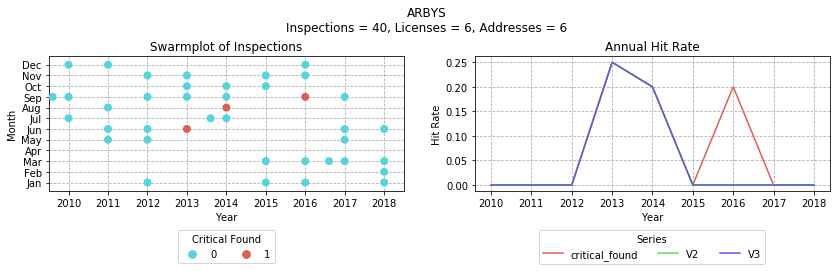

In [56]:
plot_inspections(arbys)

## Common Restaurant Inspections Over Time

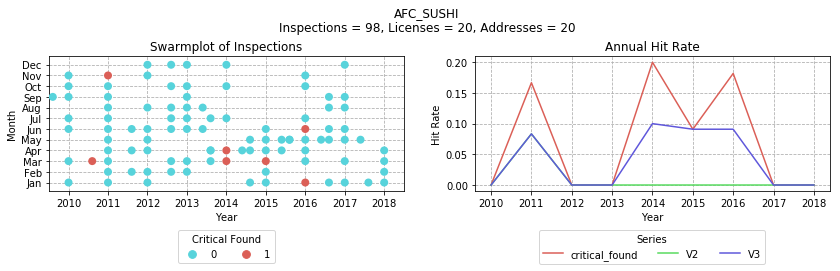

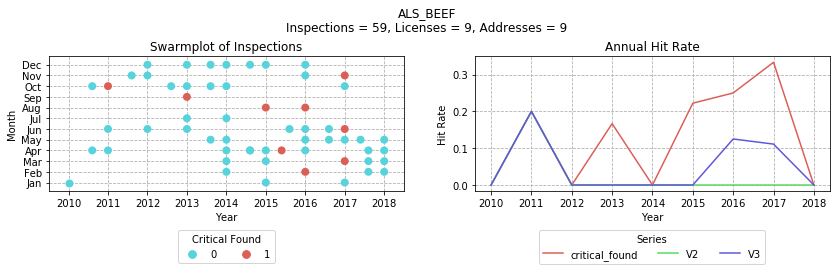

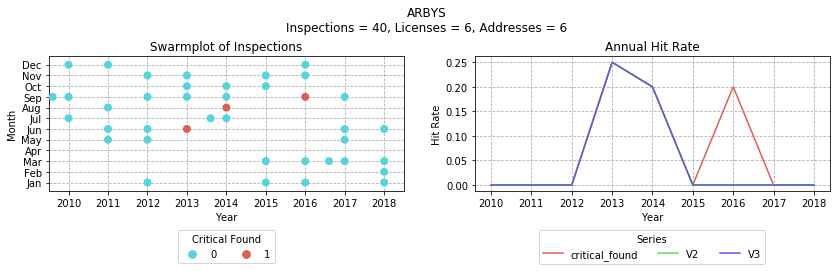

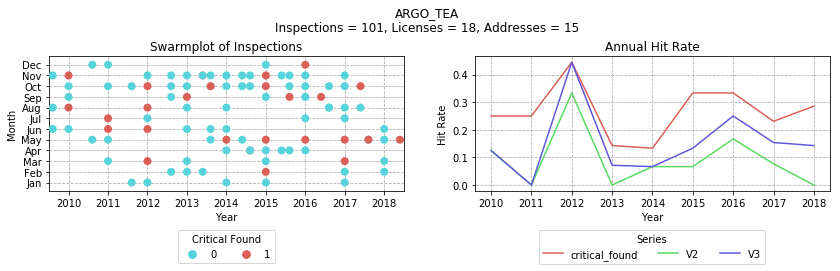

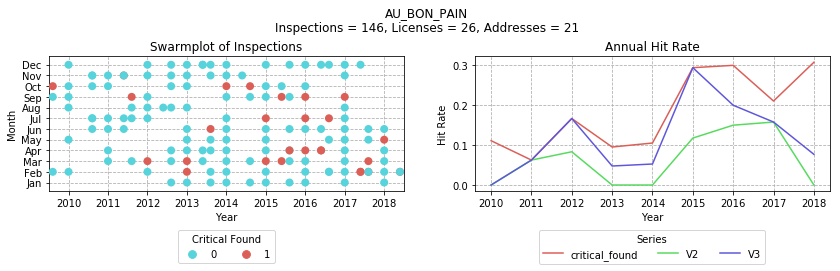

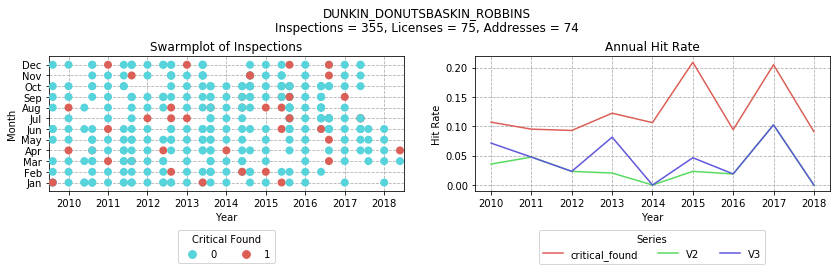

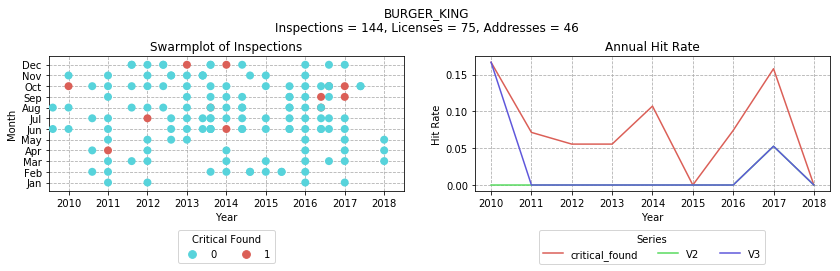

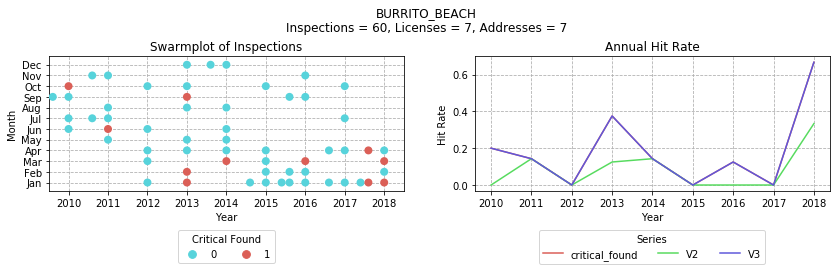

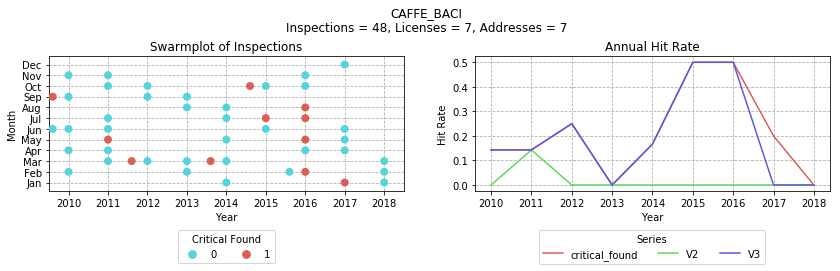

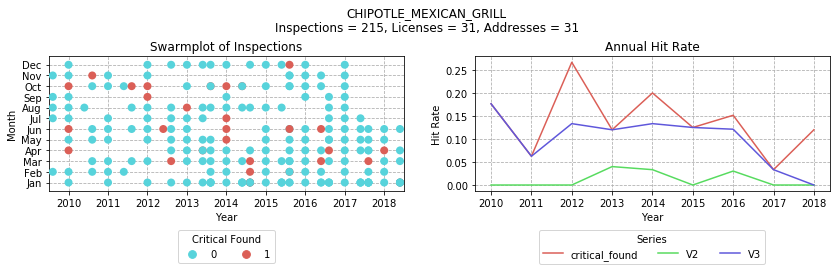

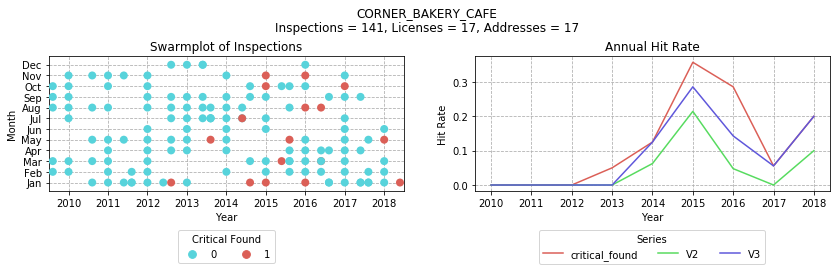

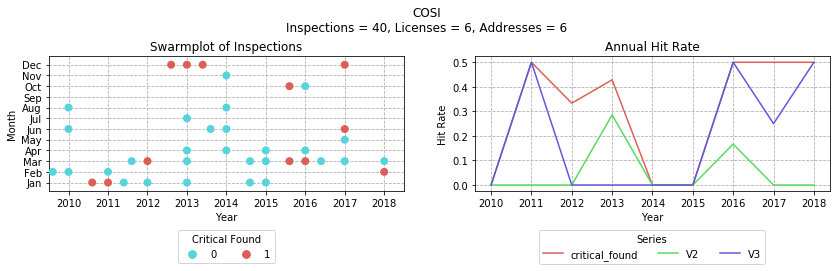

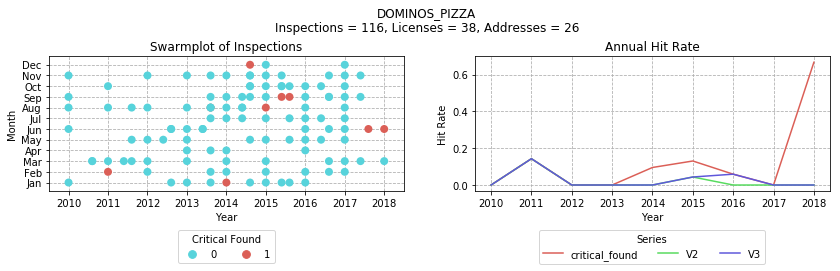

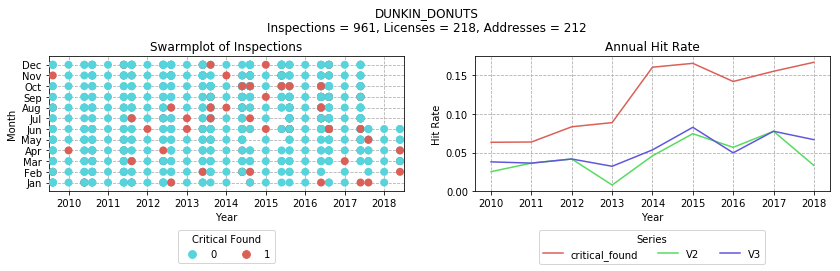

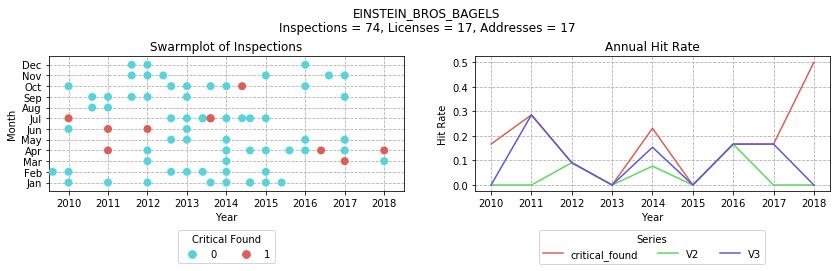

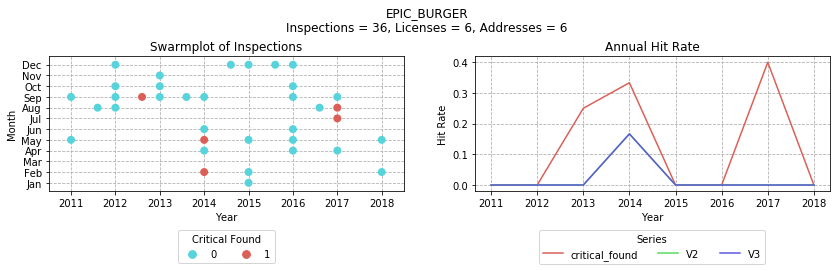

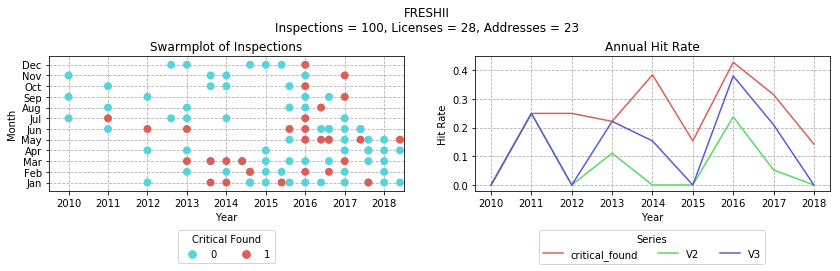

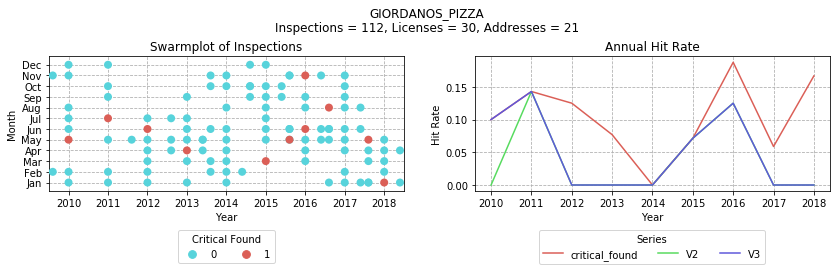

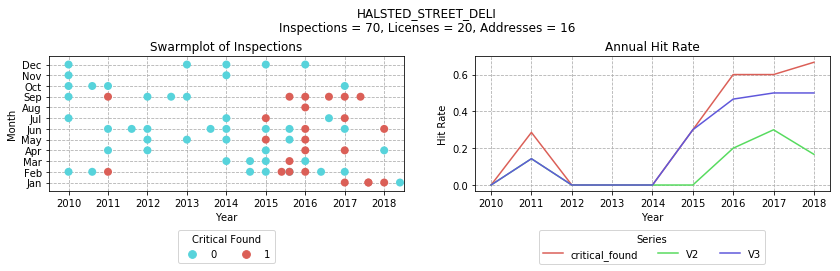

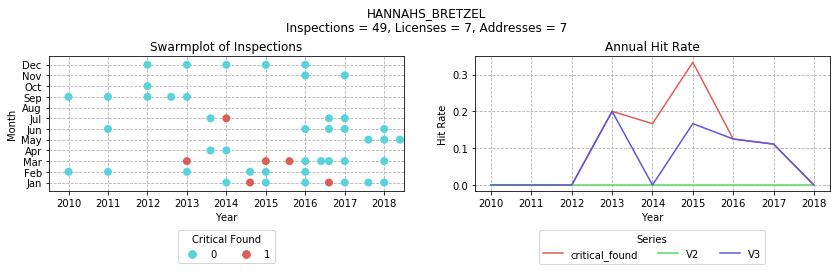

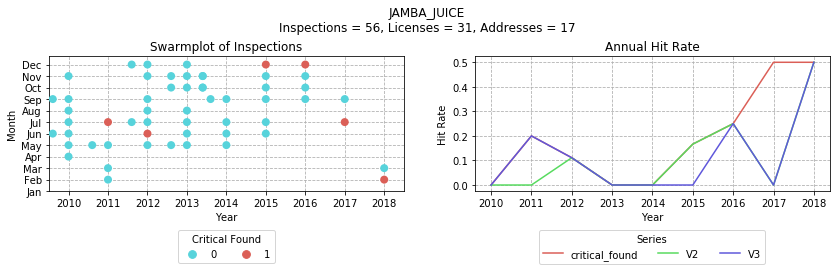

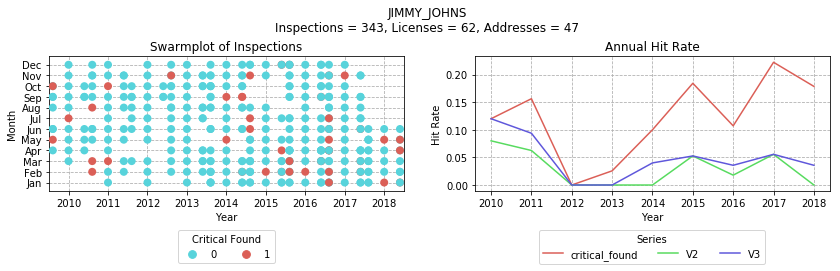

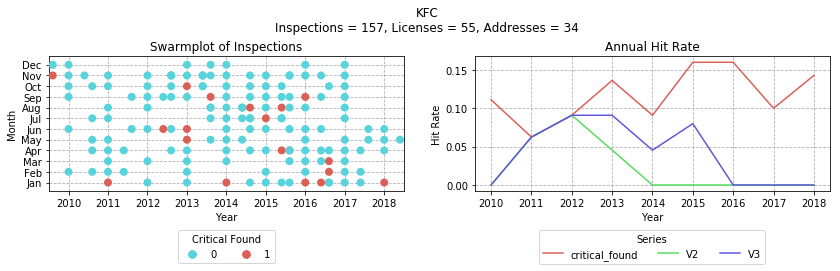

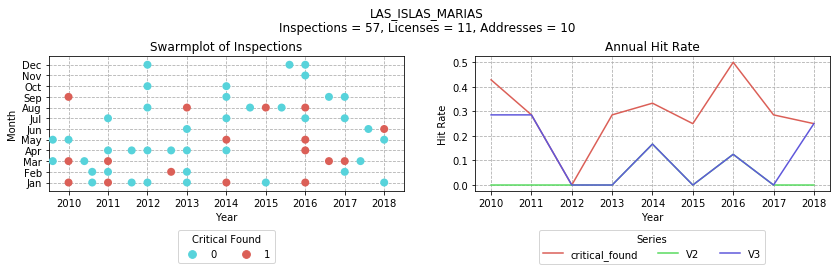

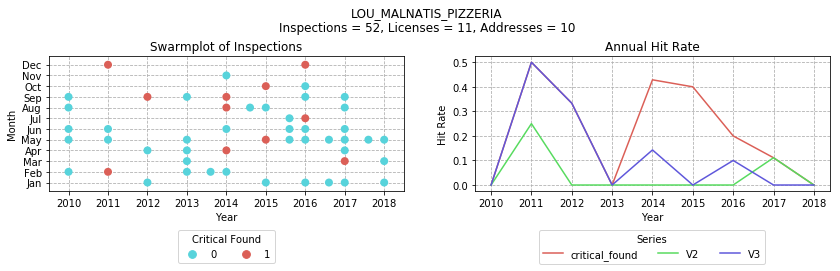

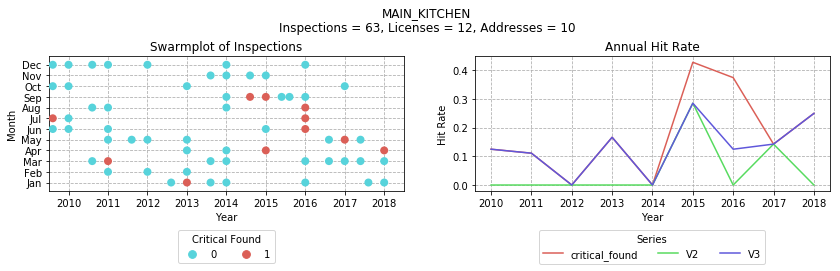

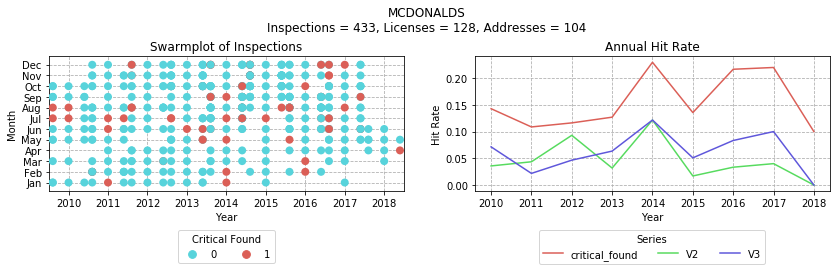

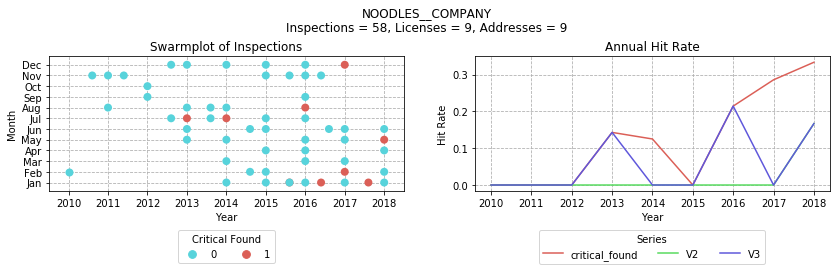

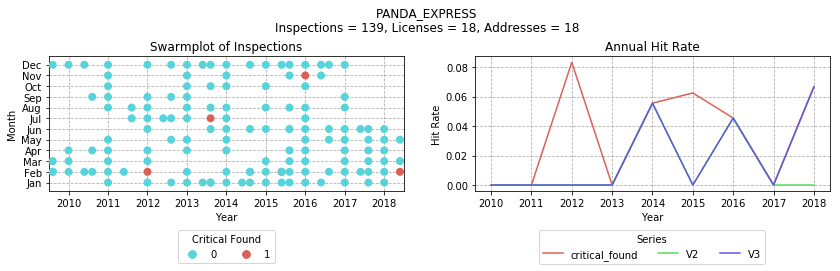

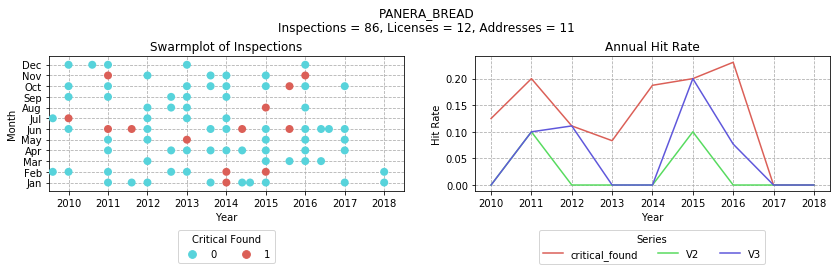

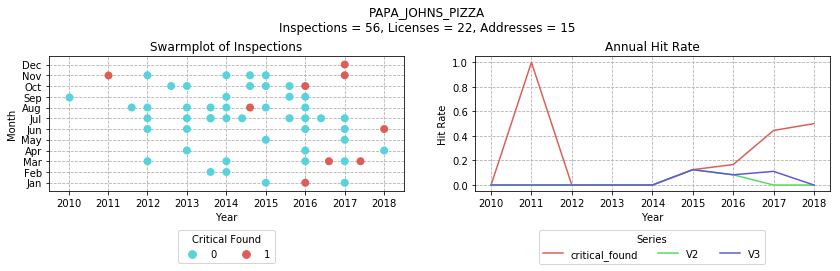

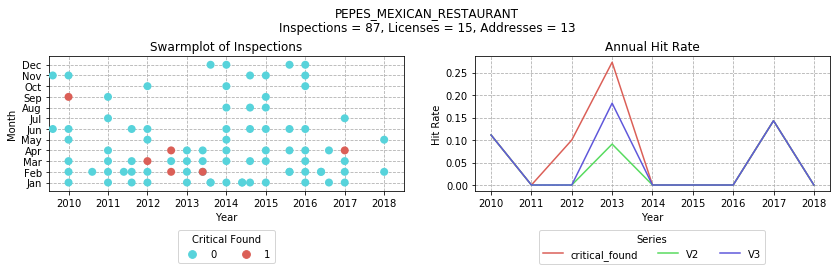

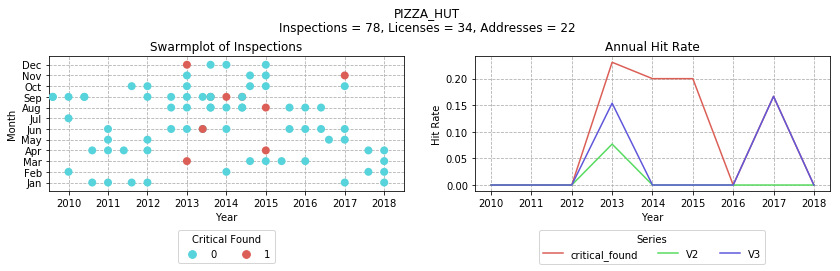

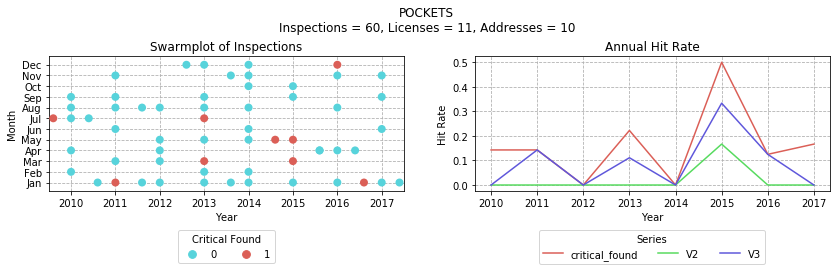

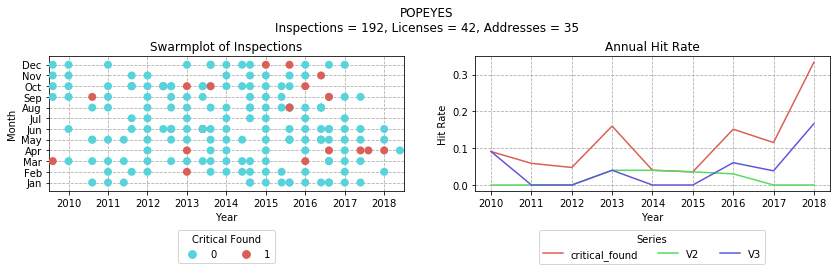

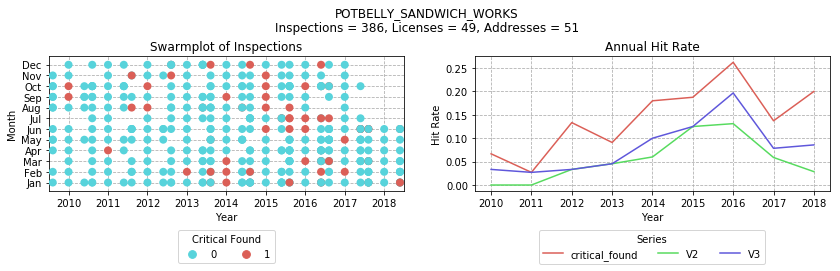

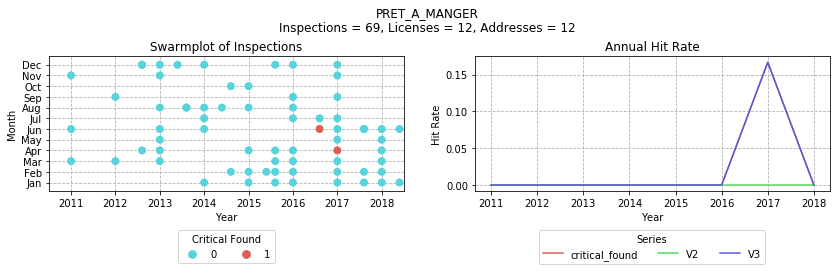

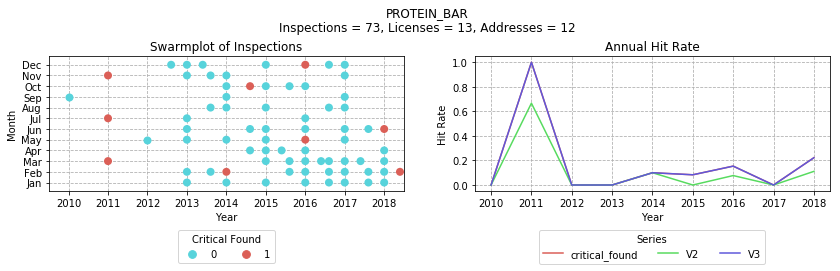

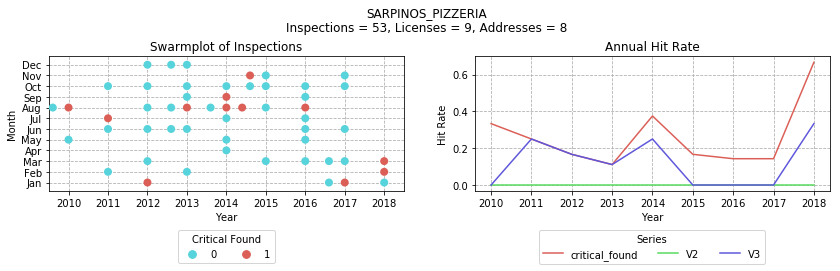

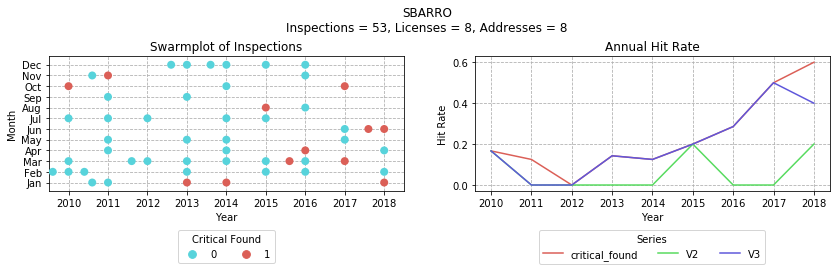

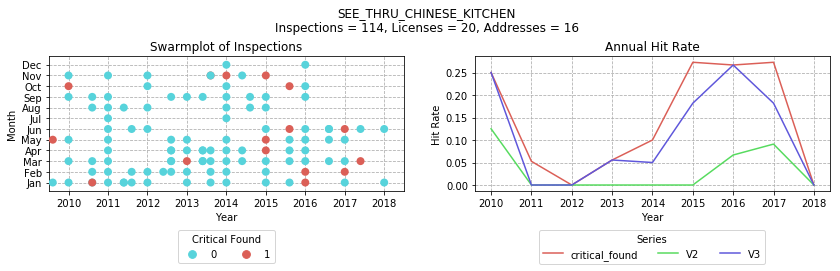

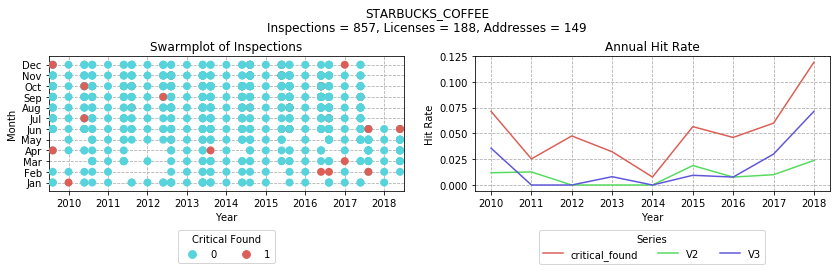

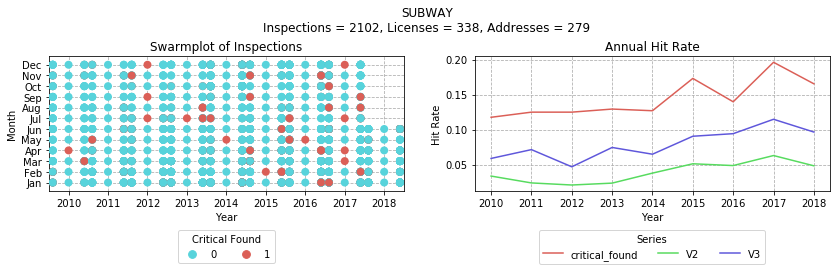

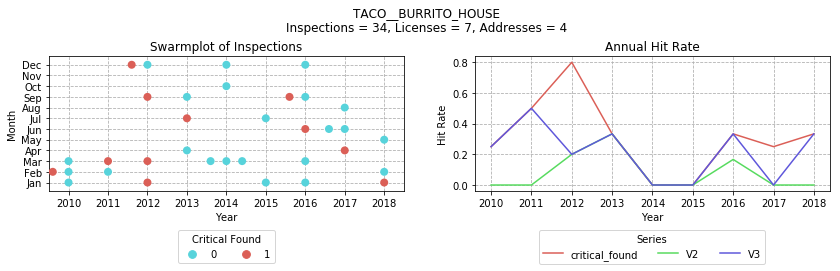

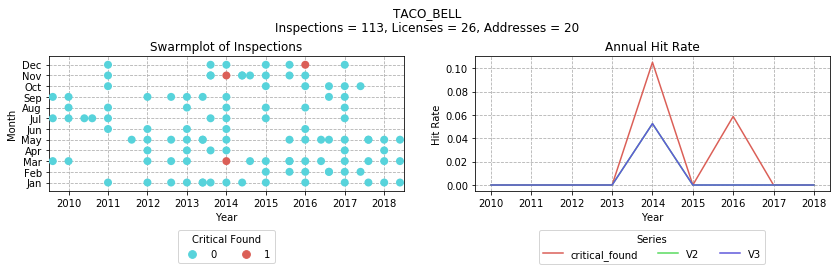

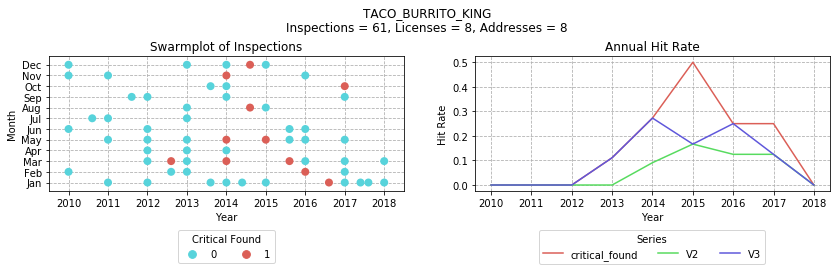

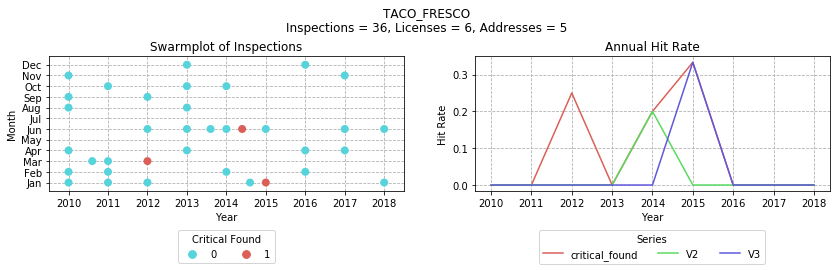

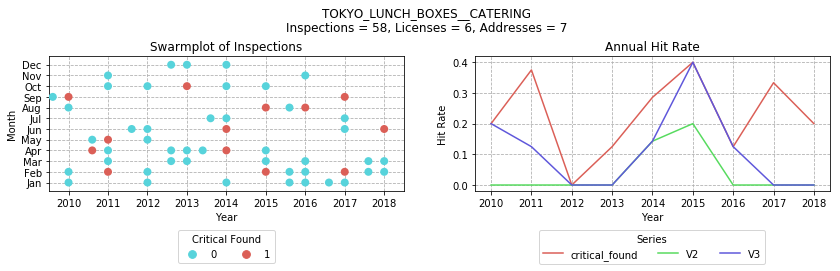

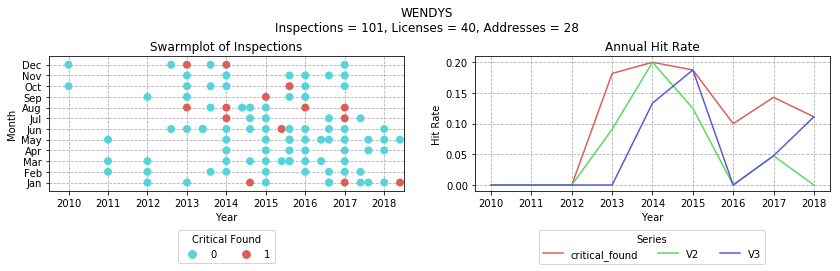

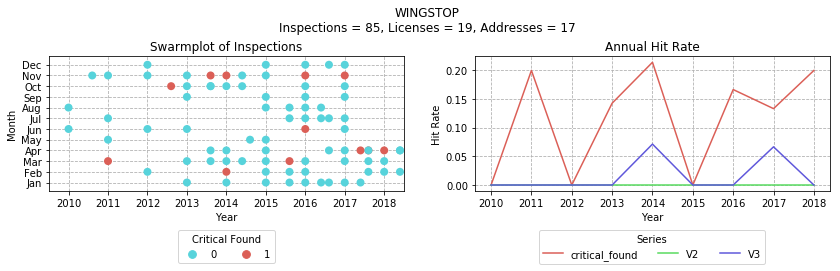

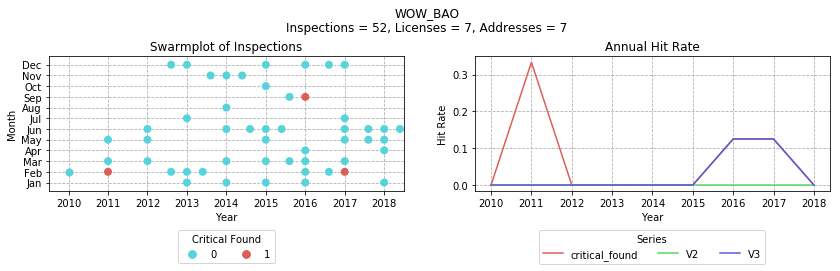

In [57]:
for label_name in mlb.classes_:
    sub_df = df_rests[rest_mat_df[label_name].values == 1]
    plot_inspections(sub_df)